In [2]:
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
from plots.mpltoolkit import named_colors, mpl_loc, fancy_legend, markers, load_mpl_presets
from scipy.stats import linregress
from scipy.optimize import bisect
from scipy.integrate import quad
import numpy as np
import vice
import sys
load_mpl_presets()
print(sys.version_info)
mpl.rcParams["axes.linewidth"] = 0.5
mpl.rcParams["figure.titlesize"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14
mpl.rcParams["legend.fontsize"] = 14

sys.version_info(major=3, minor=10, micro=2, releaselevel='final', serial=0)


# Is there a GCE model with no sink terms that predicts the Galaxy be in equilibrium on long timescales?

To answer this question, we simply assert that for a fiducial choice of star formation history, there should be *a* choice of GCE parameters as a function of radius that satisfies the requirements. We take the rise-fall SFH from Johnson et al. (2021) because it affords independent control over *both* the rising and falling components of the SFH. It is given by

$$
\dot{M}_\star \propto \left(1 - e^{-t / \tau_\text{rise}}\right) e^{-t / \tau_\text{sfh}},
$$

where $\tau_\text{rise}$ and $\tau_\text{sfh}$ are the timescales controling the rising and falling components, respectively.

Following Weinberg, Andrews & Freudenburg (2017), the evolution of the O abundance (or more generically the alpha element abundance) can be expressed as

$$
\begin{align}
\dot{Z}_\alpha &= \frac{y_\alpha}{\tau_\star} -
\frac{Z_\alpha}{\tau_\star} \left(1 + \eta - r + \tau_\star \frac{\ddot{M}_\star}{\dot{M}_\star}\right)
\\
&= \frac{y_\alpha}{\tau_\star} -
\frac{Z_\alpha}{\tau_\star}\left(1 + \eta - r +
\frac{\tau_\star}{\tau_\text{rise}}\left(\frac{e^{-t / \tau_\text{rise}}}{1 - e^{-t / \tau_\text{rise}}}\right)
- \frac{\tau_\star}{\tau_\text{sfh}}
\right)
\\
\implies \dot{Z}_\alpha + Z_\alpha
\left(
\frac{1}{\tau_\text{dep}} + \frac{
    e^{-t / \tau_\text{rise}}
}{
    \tau_\text{rise} (1 - e^{-t / \tau_\text{rise}})
} -
\frac{1}{\tau_\text{sfh}}\right) &= \frac{y_\alpha}{\tau_\star}
\end{align}
$$

The above is a linear ODE, which can be solved analytically. The solution follows as

$$
\begin{align}
Z_\alpha(t) &= \frac{e^{-t / \tau_\text{dep}} e^{t / \tau_\text{sfh}}}{1 - e^{-t / \tau_\text{rise}}}
\left[\int_0^t e^{t / \tau_\text{dep}} \left(1 - e^{-t / \tau_\text{rise}}\right) e^{-t / \tau_\text{sfh}}
\frac{y_\alpha}{\tau_\star} dt + C\right]
\\
&= \frac{e^{-t / \bar{\tau}_\text{[dep,sfh]}}}{1 - e^{-t / \tau_\text{rise}}}
\left[ \frac{y_\alpha}{\tau_\star} \int_0^t 
\left(e^{t / \bar{\tau}_\text{[dep,sfh]}} - e^{t / \bar{\tau}_\text{[dep,rise,sfh]}}\right)
dt + C\right]
\\
&= \frac{e^{-t / \bar{\tau}_\text{[dep,sfh]}}}{1 - e^{-t / \tau_\text{rise}}}
\left( \frac{y_\alpha}{\tau_\star} \right)
\Bigg[\Big[
\bar{\tau}_\text{[dep,sfh]} e^{t / \bar{\tau}_\text{[dep,sfh]}} -
\bar{\tau}_\text{[dep,rise,sfh]} e^{t / \bar{\tau}_\text{[dep,rise,sfh]}}
\Big]_0^t
+ C\Bigg]
\\
&= \frac{e^{-t / \bar{\tau}_\text{[dep,sfh]}}}{1 - e^{-t / \tau_\text{rise}}}
\left(\frac{y_\alpha}{\tau_\star}\right)
\Bigg[
\bar{\tau}_\text{[dep,sfh]} \left(e^{t / \bar{\tau}_\text{[dep,sfh]}} - 1\right) -
\bar{\tau}_\text{[dep,rise,sfh]}\left(e^{t / \bar{\tau}_\text{[dep,rise,sfh]}} - 1\right) + C
\Bigg]
\\
&= \frac{1}{1 - e^{-t / \tau_\text{rise}}}
\left(\frac{y_\alpha}{\tau_\star}\right)
\Bigg[
\bar{\tau}_\text{[dep,sfh]} \left(1 - e^{-t / \bar{\tau}_\text{[dep,sfh]}}\right) -
\bar{\tau}_\text{[dep,rise,sfh]} \left(e^{-t / \tau_\text{rise}} -
e^{-t / \bar{\tau}_\text{[dep,sfh]}}\right) + Ce^{-t / \bar{\tau}_\text{[dep,sfh]}}
\Bigg]
\\
&= \frac{y_\alpha}{1 + \eta - r - \tau_\star / \tau_\text{sfh}}
\left(\frac{1}{1 - e^{-t / \tau_\text{rise}}}\right)
\left[
1 - e^{-t / \bar{\tau}_\text{[dep,sfh]}} -
\frac{\bar{\tau}_\text{[dep,rise,sfh]}}{\bar{\tau}_\text{[dep,sfh]}}
\left(e^{-t / \tau_\text{rise}} - e^{-t / \bar{\tau}_\text{[dep,sfh]}}\right)
+ Ce^{-t / \bar{\tau}_\text{[dep,sfh]}}
\right]
\\
&= Z_{\alpha,\text{eq}} \left(\frac{1}{1 - e^{-t / \tau_\text{rise}}}\right)
\Bigg[
1 - e^{-t / \bar{\tau}_\text{[dep,sfh]}} -
\frac{\bar{\tau}_\text{[dep,rise,sfh]}}{\bar{\tau}_\text{[dep,sfh]}}
\left(e^{-t / \tau_\text{rise}} - e^{-t / \bar{\tau}_\text{[dep,sfh]}}\right)
\Bigg],
\end{align}
$$

where in the final equality I have substituted in the equilibrium abundance $Z_{\alpha,\text{eq}} \equiv y_\alpha / (1 + \eta - r - \tau_\star / \tau_\text{sfh})$ for this SFH. I have also dropped the integration constant $C$ as it is now clear that $C = 0$ is the only physical solution. Any other choice leads to $Z_\alpha(t = 0) = \infty$, violating the boundary condition that $Z_\alpha(t = 0) = 0$.

In general, we are interested in the limiting case of $\eta = 0$ in the above expression. This choice will produce an equilibrium abundance that is uniquely determined by the ratio $\tau_\star / \tau_\text{sfh}$, so the interesting question to consider is whether or not this is sufficient to produce variations in chemical equilibrium that resemble the present day abundance gradient. One simplified way to go about this is to simply set the equilibrium abundance *equal* to the radial gradient:

$$
\begin{align}
Z_{\alpha,\odot} e^{-(R - R_\odot) / R_\alpha} &= Z_{\alpha,\text{eq}}
\\
&= \frac{y_\alpha}{1 - r - \tau_\star / \tau_\text{sfh}}
\\
\implies 1 - r - \frac{\tau_\star}{\tau_\text{sfh}} &= \frac{y_\alpha}{Z_{\alpha,\odot}}
e^{(R - R_\odot) / R_\alpha}
\\
\implies \tau_\text{sfh} &=
\frac{\tau_\star}{1 - r - \frac{y_\alpha}{Z_{\alpha,\odot}} e^{(R - R_\odot) / R_\alpha}}.
\end{align}
$$

Regardless of the choice of $\tau_\star$, this expression already indicates something fundamental about the implied SFHs. Due to the denominator, the inferred value will be negative across much of the Galactic disk. For a Kroupa (2001) IMF, $1 - r \approx 0.6$, a value which is *relatively* time-independent due to the steep nature of the mass-lifetime relation.

Therefore, $\tau_\text{sfh} \leq 0$ at radii where

$$
\begin{align}
1 - r &\leq \frac{y_\alpha}{Z_{\alpha,\odot}} e^{(R - R_\odot) / R_\alpha}
\\
\ln\left((1 - r) \frac{Z_{\alpha,\odot}}{y_\alpha}\right) &\leq \frac{R - R_\odot}{R_\alpha}
\\
R &\geq R_\odot + R_\alpha \ln \left((1 - r) \frac{Z_{\alpha,\odot}}{y_\alpha}\right)
\\
&\geq R_\odot - \frac{1}{\nabla\text{[$\alpha$/H]} \ln 10} \ln
\left((1 - r) \frac{Z_{\alpha,\odot}}{y_\alpha}\right).
\end{align}
$$

At this point, it is useful to simply compute a few values of this radius at which $\tau_\text{sfh}$ diverges for a few different choices of $\nabla\text{[$\alpha$/H]}$ and $y_\alpha / Z_{\alpha,\odot}$.

In [2]:
def rcutoff(gradient = -0.06, yieldratio = 1):
    return 8 - np.log(0.6 / yieldratio) / (gradient * np.log(10))

for slope in [-0.04, -0.06, -0.08]:
    for ratio in [1, 2, 3]:
        print(slope, ratio, rcutoff(gradient = slope, yieldratio = ratio))

-0.04 1 2.453781259591091
-0.04 2 -5.07196863200844
-0.04 3 -9.474250108400469
-0.06 1 4.302520839727394
-0.06 2 -0.7146457546722935
-0.06 3 -3.6495000722669797
-0.08 1 5.2268906297955455
-0.08 2 1.4640156839957799
-0.08 3 -0.7371250542002343


| slope | yieldratio = 1 | yieldratio = 2 | yieldratio = 3 |
| :------------: | :------------: | :------------: | :------------: |
| $-0.04$ dex/kpc | $2.45$ kpc | $-5.07$ kpc | $-9.47$ kpc |
| $-0.06$ dex/kpc | $4.30$ kpc | $-0.715$ kpc | $-3.65$ kpc |
| $-0.08$ dex/kpc | $5.22$ kpc | $1.46$ kpc | $-0.737$ kpc |

The required star formation histories, interestingly, would have to be increasing monotonically with time over much of the disk radii if not the entire disk in order to reproduce this result.

In [3]:
_SECONDS_PER_GYR_ = 3.1536e16 # conversion factor
_KM_PER_KPC_ = 3.24e-17 # conversion factor
TAUDISK = 13.2

def harmonic(*args):
    if len(args) > 0:
        s = 1 / args[0]
        for arg in args[1:]: s -= 1 / arg
        return 1 / s
    else:
        raise TypeError("At least one argument expected.")

class risefall_sfh:

    def __init__(self, taurise = 2, tausfh = 6):
        self.taurise = taurise
        self.tausfh = tausfh

    def __call__(self, t):
        return (1 - np.exp(-t / self.taurise)) * np.exp(-t / self.tausfh)

class risefall_zalpha:

    def __init__(self, radius, taurise = 2, tausfh = 6, yieldsolar = 1, gradient = -0.06, eta = 0,
        taustar0 = 2, Rg = 3.75, N = 1.5, recycling = 0.4):
        self.radius = radius
        self.taurise = taurise
        self.tausfh = tausfh
        self.yalpha = yieldsolar * vice.solar_z['o']
        self.gradient = gradient
        self.eta = eta
        self.taustar = taustar0 * np.exp((N - 1) * self.radius / Rg)
        self.recycling = recycling
        
    def __call__(self, time):
        if time == 0: return 0
        taudep = self.taustar / (1 + self.eta - self.recycling)
        term1 = 1 - np.exp(-time / harmonic(taudep, self.tausfh))
        term2 = harmonic(taudep, self.taurise, self.tausfh) / harmonic(taudep, self.tausfh)
        term2 *= (np.exp(-time / self.taurise) - np.exp(-time / harmonic(taudep, self.tausfh)))
        return self.equilibrium / (1 - np.exp(-time / self.taurise)) * (term1 - term2)

    @property
    def equilibrium(self):
        return self.yalpha / (1 + self.eta - self.recycling - self.taustar / self.tausfh)

    @staticmethod
    def at_present_day(radius, **kwargs):
        model = risefall_zalpha(radius, **kwargs)
        return model(TAUDISK)
    
    @staticmethod
    def percentile(N, taudisk = TAUDISK, taurise = 2, tausfh = 6):
        def fsfh(t):
            return (1 - np.exp(-t / taurise)) * np.exp(-t / tausfh)
        def driver(taun):
            term1 = quad(fsfh, taudisk - taun, taudisk)[0]
            term2 = N / 100 * quad(fsfh, 0, taudisk)[0]
            return term1 - term2
        try:
            result = bisect(driver, 0, taudisk)
        except ValueError:
            return float("nan")
        if result > 0.1:
            return result
        else:
            return float("nan")
    
    @staticmethod
    def eq_ratio(radius, **kwargs):
        model = risefall_zalpha(radius, **kwargs)
        return model(TAUDISK) / model.equilibrium
    
    @staticmethod
    def gradient(radius, slope = -0.06):
        ralpha = -(np.log(10) * slope)**(-1)
        return vice.solar_z['o'] * np.exp(-(radius - 8) / ralpha)

In [4]:
_DEFAULT_KWARGS_ = {
    "gradient": -0.06,
    "yieldsolar": 1,
    "eta": 0,
    "taustar0": 2,
    "Rg": 3.75,
    "N": 1.5,
    "recycling": 0.4
}
_KWARGS_ = _DEFAULT_KWARGS_.copy()

def find_tausfh_driver(tausfh, radius, taurise):
    diff = risefall_zalpha.at_present_day(radius, tausfh = tausfh, taurise = taurise, **_KWARGS_)
    diff -= risefall_zalpha.gradient(radius, slope = _KWARGS_["gradient"])
    return diff

def find_taurise_driver(taurise, radius, tausfh):
    diff = risefall_zalpha.at_present_day(radius, tausfh = tausfh, taurise = taurise, **_KWARGS_)
    diff -= risefall_zalpha.gradient(radius, slope = _KWARGS_["gradient"])
    return diff

def find_tausfh_taurise(radius, **kwargs):
    for key in _DEFAULT_KWARGS_.keys():
        if key in kwargs.keys():
            _KWARGS_[key] = kwargs[key]
        else:
            _KWARGS_[key] = _DEFAULT_KWARGS_[key]
    taurise = 2
    tausfhmax = 200
    if (find_tausfh_driver(0.1, radius, taurise) *
        find_tausfh_driver(tausfhmax, radius, taurise) < 0):
        tausfh = bisect(find_tausfh_driver, 0.1, tausfhmax, args = (radius, taurise))
        return [tausfh, taurise]
    elif (find_taurise_driver(0.1, radius, tausfhmax) *
        find_taurise_driver(2 * TAUDISK, radius, tausfhmax) < 0):
        taurise = bisect(find_taurise_driver, 0.1, 2 * TAUDISK, args = (radius, tausfhmax))
        return [tausfhmax, taurise]
    else:
        return [float("nan"), float("nan")]

In [ ]:
YIELDSOLAR = 1

fig = plt.figure(figsize = (3.5, 4.5))
top = fig.add_subplot(111)
bottom = fig.add_axes([0.1, 0.1, 0.1, 0.1], sharex = top)
bottom.set_xlabel(r"$R_\text{gal}$ [kpc]")
plt.setp(top.get_xticklabels(), visible = False)
top.set_ylabel(r"Median Age [Gyr]")
bottom.set_ylabel(r"$Z_\text{O} / Z_\text{O,eq}$")
top.set_xlim([0, 15])
top.set_ylim([2.5, 10])
top.set_yticks([4, 6, 8, 10])
bottom.set_ylim([0, 1])
bottom.set_yticks([0, 0.5, 1])

apogee = np.genfromtxt("./empirical/agefit.out")
centers = [(a + b) / 2 for a, b in zip(apogee[:, 0], apogee[:, 1])]
top.scatter(centers, apogee[:, 3], c = named_colors()["black"],
    marker = markers()["star"], s = 50, zorder = 90, label = "APOGEE")
top.legend(loc = mpl_loc("upper right"), fontsize = 12)

def plot_behavior(keywordarg, value, **plot_kwargs):
    xvals = np.linspace(0, 15, 100)
    kwargs = {keywordarg: value}
    if keywordarg != "yieldsolar": kwargs["yieldsolar"] = YIELDSOLAR
#     for key in calc_kwargs.keys(): kwargs[key] = calc_kwargs[key]
#     kwargs = {
#         keywordarg: value,
#         "yieldsolar": YIELDSOLAR
#     }
    raw = [find_tausfh_taurise(_, **kwargs) for _ in xvals]
    yvals = [risefall_zalpha.percentile(50, tausfh = _[0], taurise = _[1]) for _ in raw]
    eq_ratios = []
    for i in range(len(xvals)): eq_ratios.append(risefall_zalpha.eq_ratio(xvals[i],
        tausfh = raw[i][0], taurise = raw[i][1], **kwargs))
    top.plot(xvals, yvals, **plot_kwargs)
    bottom.plot(xvals, eq_ratios, **plot_kwargs)

plot_behavior("gradient", -0.06, c = named_colors()["black"], zorder = 100, linewidth = 2)
plot_behavior("gradient", -0.04, c = named_colors()["crimson"], linestyle = ":", zorder = 40)
plot_behavior("gradient", -0.08, c = named_colors()["crimson"], linestyle = "--", zorder = 40)
plot_behavior("Rg", 3.25, c = named_colors()["blue"], linestyle = ":", zorder = 30)
plot_behavior("Rg", 4.25, c = named_colors()["blue"], linestyle = "--", zorder = 30)
plot_behavior("N", 1.4, c = named_colors()["lime"], linestyle = ":", zorder = 20)
plot_behavior("N", 1.6, c = named_colors()["lime"], linestyle = "--", zorder = 20)
# plot_behavior("eta", 2, calc_kwargs = {"yieldsolar": 2}, plot_kwargs = {"c": named_colors()["black"]})

# top.plot([5, 6.5], 2 * [7.15], c = named_colors()["black"], linestyle = ":")
# top.plot([5, 6.5], 2 * [7.9], c = named_colors()["black"], linestyle = "-")
# top.plot([5, 6.5], 2 * [8.65], c = named_colors()["black"], linestyle = "--")
# kwargs = {"fontsize": 11}
# top.text(8.25, 9.25, r"$\nabla$", c = named_colors()["crimson"], **kwargs)
# top.text(7, 7, r"$-0.04$", c = named_colors()["crimson"], **kwargs)
# top.text(7, 7.75, r"$-0.06$", **kwargs)
# top.text(7, 8.5, r"$-0.08$", c = named_colors()["crimson"], **kwargs)
# top.text(10.25, 9.25, r"$N$", c = named_colors()["lime"], **kwargs)
# top.text(10, 7, r"$1.4$", c = named_colors()["lime"], **kwargs)
# top.text(10, 7.75, r"$1.5$", **kwargs)
# top.text(10, 8.5, r"$1.6$", c = named_colors()["lime"], **kwargs)
# top.text(12.25, 9.25, r"$R_g$", c = named_colors()["blue"], **kwargs)
# top.text(12, 7, r"$3.25$", c = named_colors()["blue"], **kwargs)
# top.text(12, 7.75, r"$3.75$", **kwargs)
# top.text(12, 8.5, r"$4.25$", c = named_colors()["blue"], **kwargs)

plt.tight_layout()
plt.subplots_adjust(bottom = 0.4)
bottom.set_position([
    top.get_position().x0,
    0.12,
    top.get_position().x1 - top.get_position().x0,
    top.get_position().y0 - 0.12
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./no-sink-eq/medage-vs-radius.%s" % (ext), **kwargs)
plt.show()

/var/folders/1p/lm_h7y810f9_7ygnvr2tjc_w0000gn/T/ipykernel_34282/1596708548.py:57: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  term1 = quad(fsfh, taudisk - taun, taudisk)[0]
/var/folders/1p/lm_h7y810f9_7ygnvr2tjc_w0000gn/T/ipykernel_34282/1596708548.py:58: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  term2 = N / 100 * quad(fsfh, 0, taudisk)[0]
/var/folders/1p/lm_h7y810f9_7ygnvr2tjc_w0000gn/T/ipykernel_34282/1596708548.py:57: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  term1 = quad(fsfh, taudisk - taun, taudisk)[0]
/var/folders/1p/lm_h7y810f9_7ygnvr2tjc_w0000gn/T/ipykernel_34282/1596708548.py:57: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  in

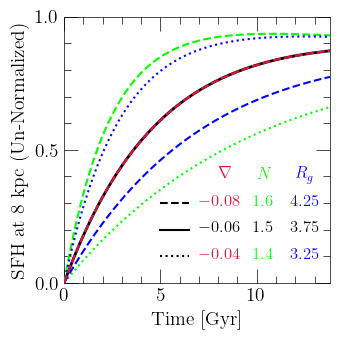

In [86]:
YIELDSOLAR = 1

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Time [Gyr]")
ax.set_ylabel(r"SFH at $8$ kpc (Un-Normalized)")
ax.set_xlim([0, 13.8])
# ax.set_ylim([0.03, 3])
ax.set_ylim([0, 1])
ax.set_yticks([0, 0.5, 1])
# ax.set_yscale("log")
# ax.yaxis.set_major_formatter(fsf("%g"))

def plot_sfh(keywordarg, value, **plot_kwargs):
    xvals = np.linspace(0, 13.8, 1000)
    kwargs = {keywordarg: value}
    if keywordarg != "yieldsolar": kwargs["yieldsolar"] = YIELDSOLAR
    tausfh, taurise = find_tausfh_taurise(8, **kwargs)
    sfh = risefall_sfh(taurise = taurise, tausfh = tausfh)
    yvals = [sfh(x) for x in xvals]
    ax.plot(xvals, yvals, **plot_kwargs)

plot_sfh("gradient", -0.06, c = named_colors()["black"], zorder = 1, linewidth = 2)
plot_sfh("gradient", -0.04, c = named_colors()["crimson"], linestyle = ":", zorder = 40)
plot_sfh("gradient", -0.08, c = named_colors()["crimson"], linestyle = "--", zorder = 40)
plot_sfh("Rg", 3.25, c = named_colors()["blue"], linestyle = ":", zorder = 30)
plot_sfh("Rg", 4.25, c = named_colors()["blue"], linestyle = "--", zorder = 30)
plot_sfh("N", 1.4, c = named_colors()["lime"], linestyle = ":", zorder = 20)
plot_sfh("N", 1.6, c = named_colors()["lime"], linestyle = "--", zorder = 20)

ax.plot([5, 6.5], 2 * [0.1], c = named_colors()["black"], linestyle = ":")
ax.plot([5, 6.5], 2 * [0.2], c = named_colors()["black"], linestyle = "-")
ax.plot([5, 6.5], 2 * [0.3], c = named_colors()["black"], linestyle = "--")
kwargs = {"fontsize": 12}
ax.text(8, 0.39, r"$\nabla$", c = named_colors()["crimson"], **kwargs)
ax.text(7, 0.09, r"$-0.04$", c = named_colors()["crimson"], **kwargs)
ax.text(7, 0.19, r"$-0.06$", **kwargs)
ax.text(7, 0.29, r"$-0.08$", c = named_colors()["crimson"], **kwargs)
ax.text(10, 0.39, r"$N$", c = named_colors()["lime"], **kwargs)
ax.text(9.8, 0.09, r"$1.4$", c = named_colors()["lime"], **kwargs)
ax.text(9.8, 0.19, r"$1.5$", **kwargs)
ax.text(9.8, 0.29, r"$1.6$", c = named_colors()["lime"], **kwargs)
ax.text(12, 0.39, r"$R_g$", c = named_colors()["blue"], **kwargs)
ax.text(11.7, 0.09, r"$3.25$", c = named_colors()["blue"], **kwargs)
ax.text(11.7, 0.19, r"$3.75$", **kwargs)
ax.text(11.7, 0.29, r"$4.25$", c = named_colors()["blue"], **kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./no-sink-eq/implied-sfhs.%s" % (ext), **kwargs)
plt.show()